# Cat in dat II
### This is the cat in dat II competition where you must use 24 features for binary classification. Credit to Jian Yang for inspiration on this notebook.

In [10]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from deeptables.models.deeptable import ModelConfig, DeepTable
from tensorflow.keras.utils import plot_model
from scipy.stats import zscore

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.
X = pd.read_csv(f'../input/cat-in-the-dat-ii/train.csv')
y = X['target']
test = pd.read_csv(f'../input/cat-in-the-dat-ii/test.csv')

catID = test['id']

X = X.drop('id', axis=1)
X = X.drop('target', axis=1)
test = test.drop('id', axis=1)

/kaggle/input/cat-in-the-dat-ii/train.csv
/kaggle/input/cat-in-the-dat-ii/test.csv
/kaggle/input/cat-in-the-dat-ii/sample_submission.csv


In [11]:
ord_order = [
    [1.0, 2.0, 3.0],
    ['Novice', 'Contributer', 'Expert', 'Master', 'Grandmaster'],
    ['Freezing', 'Cold', 'Warm', 'Hot', 'Boiling Hot', 'Lava Hot']
]

for i in range(1, 3):
    ord_order_dict = {i : j for j, i in enumerate(ord_order[i])}
    X[f'ord_{i}_en'] = X[f'ord_{i}'].fillna('NULL').map(ord_order_dict)
    test[f'ord_{i}_en'] = test[f'ord_{i}'].fillna('NULL').map(ord_order_dict)

for i in range(3, 6):
    ord_order_dict = {i : j for j, i in enumerate(sorted(list(set(list(X[f'ord_{i}'].dropna().unique()) + list(test[f'ord_{i}'].dropna().unique())))))}
    X[f'ord_{i}_en'] = X[f'ord_{i}'].fillna('NULL').map(ord_order_dict)
    test[f'ord_{i}_en'] =  test[f'ord_{i}'].fillna('NULL').map(ord_order_dict)

In [12]:
cat_cols = [i for i in X.columns if '_en' not in i]
X[cat_cols] = X[cat_cols].astype('category')
test[cat_cols] = test[cat_cols].astype('category')

In [13]:
X.head()

,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,...,ord_3,ord_4,ord_5,day,month,ord_1_en,ord_2_en,ord_3_en,ord_4_en,ord_5_en
0,0.0,0.0,0.0,F,N,Red,Trapezoid,Hamster,Russia,Bassoon,...,c,U,Pw,6.0,3.0,NaN,3.0,2.0,20.0,56.0
1,1.0,1.0,0.0,F,Y,Red,Star,Axolotl,NaN,Theremin,...,e,X,pE,7.0,7.0,4.0,2.0,4.0,23.0,150.0
2,0.0,1.0,0.0,F,N,Red,NaN,Hamster,Canada,Bassoon,...,n,P,eN,5.0,9.0,NaN,0.0,13.0,15.0,105.0
3,NaN,0.0,0.0,F,N,Red,Circle,Hamster,Finland,Theremin,...,a,C,NaN,3.0,3.0,0.0,5.0,0.0,2.0,NaN
4,0.0,NaN,0.0,T,N,Red,Triangle,Hamster,Costa Rica,NaN,...,h,C,OZ,5.0,12.0,4.0,1.0,7.0,2.0,50.0


## Deeptables
### The following model is an ensemble of neural networks called deeptables. Its parameters are defined through ModelConfig.

In [14]:
config = ModelConfig(
    dnn_params={
        'hidden_units':((200, 0.3, True),(200, 0.3, True),), #hidden_units
        'dnn_activation':'relu',
    },
    embeddings_output_dim=20,
    nets =['linear','cin_nets','dnn_nets'],
    output_use_bias = False,
    cin_params={
       'cross_layer_size': (200, 200),
       'use_bias': True,
       'direct': True
    },
)
model = DeepTable(config=config)

In [15]:
oof_proba, eval_proba, test_prob = model.fit_cross_validation(
    X, y, X_eval=None, X_test=test, num_folds=3, stratified=False, iterators=None, batch_size=128, epochs=1, verbose=1, callbacks=[], n_jobs=1
)

Start cross validation
2 class detected, {0, 1}, so inferred as a [binary classification] task
Preparing features cost:0.14447736740112305
Imputation cost:7.030967950820923
Categorical encoding cost:14.192986726760864
fit_transform cost:21.500080585479736
transform X_test
transform_X cost:297.79743361473083
Iterators:KFold(n_splits=3, random_state=9527, shuffle=True)
Injected a callback [EarlyStopping]. monitor:val_accuracy, patience:1, mode:max


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



Fold:1

>>>>>>>>>>>>>>>>>>>>>> Model Desc <<<<<<<<<<<<<<<<<<<<<<< 
---------------------------------------------------------
inputs:
---------------------------------------------------------
['all_categorical_vars: (23)', 'input_continuous_all: (5)']
---------------------------------------------------------
embeddings:
---------------------------------------------------------
input_dims: [4, 4, 4, 4, 4, 5, 8, 8, 8, 6, 1222, 1521, 224, 224, 2220, 5, 7, 8, 17, 28, 192, 9, 14]
output_dims: [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20]
dropout: 0.3
---------------------------------------------------------
dense: dropout: 0
batch_normalization: False
---------------------------------------------------------
concat_embed_dense: shape: (None, 465)
---------------------------------------------------------
nets: ['cin_nets', 'linear', 'dnn_nets']
---------------------------------------------------------
cin: input_shape (None, 23, 20), output_shap

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 76.8min finished


fit_cross_validation cost:4926.742518663406


## Neural network architecture
### I don't know about you, but I think that observing the insides of a neural network is pretty cool. Here's mine.

Load model from disk:dt_output/dt_20200428 132912_cin_nets_linear_dnn_nets/cin_nets_linear_dnn_nets-kfold-3.h5.


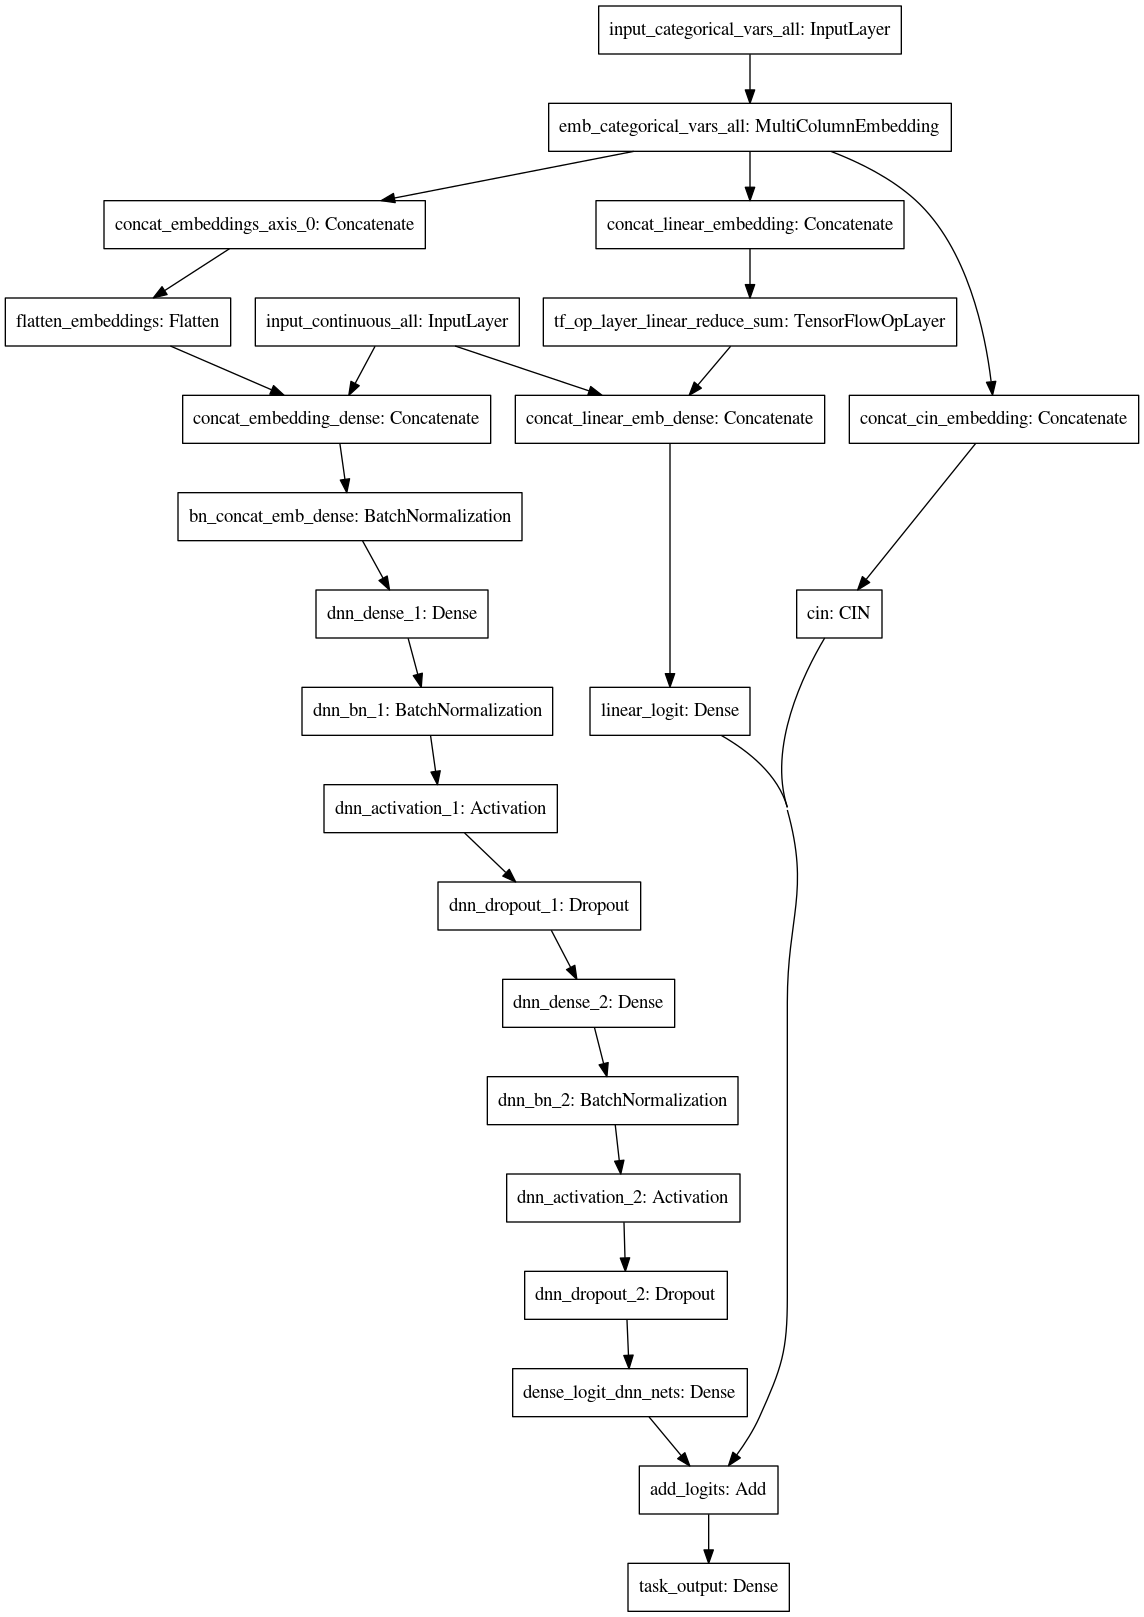

In [17]:
plot_model(model.get_model().model,rankdir='TB')

In [ ]:
submission = pd.read_csv(f'../input/cat-in-the-dat-ii/sample_submission.csv')
submission['target'] = test_prob
submission.to_csv('submission.csv', index=False)